In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
df=pd.read_csv("/content/data.csv",encoding='latin1')
df

/tmp/ipython-input-1217822186.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/data.csv",encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435737,SAMP,24-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,22.0,50.0,143.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-24
435738,SAMP,29-12-15,West Bengal,ULUBERIA,West Bengal State Pollution Control Board,RIRUO,20.0,46.0,171.0,NaN,"Inside Rampal Industries,ULUBERIA",NaN,2015-12-29
435739,NaN,NaN,andaman-and-nicobar-islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435740,NaN,NaN,Lakshadweep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
x=df["no2"].dropna().values
x

array([17.4,  7. , 28.5, ..., 45. , 50. , 46. ])

In [36]:
r=102317125
a_r=0.5*(r%7)
b_r=0.3*((r%5)+1)
z=x+a_r*np.sin(b_r*x)
z=torch.tensor(z,dtype=torch.float32).view(-1,1)

In [37]:
G = nn.Sequential(
    nn.Linear(1,64),
    nn.LeakyReLU(0.2),
    nn.Linear(64,64),
    nn.LeakyReLU(0.2),
    nn.Linear(64,1)
)

In [38]:
D = nn.Sequential(
    nn.Linear(1,64),
    nn.LeakyReLU(0.2),
    nn.Linear(64,64),
    nn.LeakyReLU(0.2),
    nn.Linear(64,1),
    nn.Sigmoid()
)

In [39]:
Loss=nn.BCELoss()
g=optim.Adam(G.parameters(),lr=0.001)
d=optim.Adam(D.parameters(),lr=0.001)

In [40]:
epochs=5000
batch=64
for i in range(1,epochs+1):

    idx=torch.randint(0,z.size(0),(batch,))
    real=z[idx]
    label_real=torch.ones(batch,1)
    label_fake=torch.zeros(batch,1)

    noise=torch.randn(batch,1)
    fake=G(noise)
    d_real=D(real)
    d_fake=D(fake.detach())
    d_loss=Loss(d_real,label_real)+Loss(d_fake,label_fake)
    d.zero_grad()
    d_loss.backward()
    d.step()

    noise=torch.randn(batch,1)
    fake=G(noise)
    g_loss=Loss(D(fake),label_real)
    g.zero_grad()
    g_loss.backward()
    g.step()

    if (i%500==0):
        print("epoch:",i,", D loss:",d_loss.item(),", G loss:",g_loss.item())

epoch: 500 , D loss: 1.3614850044250488 , G loss: 0.8128024935722351
epoch: 1000 , D loss: 1.3877789974212646 , G loss: 0.857245683670044
epoch: 1500 , D loss: 1.3902089595794678 , G loss: 0.8155888319015503
epoch: 2000 , D loss: 1.3914321660995483 , G loss: 0.7469279170036316
epoch: 2500 , D loss: 1.3811469078063965 , G loss: 0.8432307243347168
epoch: 3000 , D loss: 1.3895149230957031 , G loss: 0.9216496348381042
epoch: 3500 , D loss: 1.3755993843078613 , G loss: 0.7105728387832642
epoch: 4000 , D loss: 1.391650915145874 , G loss: 0.7154031991958618
epoch: 4500 , D loss: 1.388087272644043 , G loss: 0.6352137327194214
epoch: 5000 , D loss: 1.3880372047424316 , G loss: 0.7132400274276733


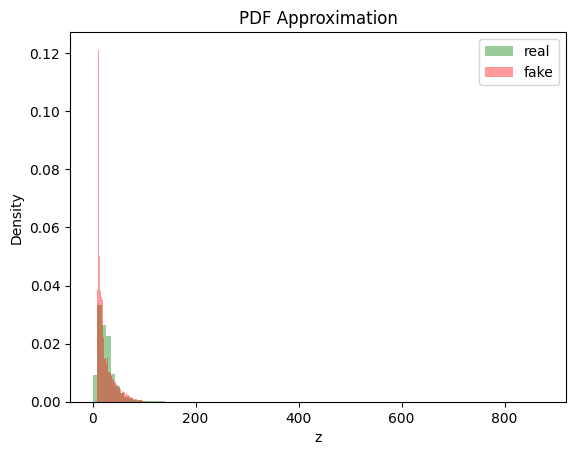

In [41]:
n=torch.randn(10000,1)
genz=G(n).detach().numpy()
plt.hist(z.numpy(),bins=100,density=True,alpha=0.4,label="real",color='g')
plt.hist(genz,bins=100,density=True,alpha=0.4,label="fake",color='r')
plt.legend()
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Approximation")
plt.show()